<a href="https://colab.research.google.com/github/sandboy1/tdm/blob/main/NVDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
# https://github.com/llSourcell/ChatGPT_Trading_Bot
# ## install finrl library
!pip install wrds
!pip install swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-luuwy6xz
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-luuwy6xz
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 7fcfbd2738822592569bc2b5654b7f0e55b51424
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-xybodflc/elegantrl_dda90c51229549ef8238c491e72662af
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundat


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
#TRAIN_START_DATE = '2009-04-01'
#TRAIN_END_DATE = '2021-01-01'
#TEST_START_DATE = '2021-01-01'
#TEST_END_DATE = '2022-06-01'
TRAIN_START_DATE = '2011-07-10'
TRAIN_END_DATE = '2022-06-01'
TEST_START_DATE = '2021-07-30'
TEST_END_DATE = '2022-12-31'  

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2011-07-11,12.726429,12.848929,12.600714,10.760567,442674400,AAPL,0
1,2011-07-11,57.209999,57.500000,56.660000,42.279652,4186300,AMGN,0
2,2011-07-11,52.500000,52.860001,52.110001,44.309212,5342400,AXP,0
3,2011-07-11,74.169998,74.730003,73.000000,59.237133,4379000,BA,0
4,2011-07-11,108.410004,109.480003,107.250000,78.658676,7568600,CAT,0


In [ ]:
df.tail()

,date,open,high,low,close,volume,tic,day
84760,2022-12-30,530.000000,530.500000,524.840027,530.179993,1849300,UNH,4
84761,2022-12-30,206.309998,208.039993,205.699997,207.353867,4159400,V,4
84762,2022-12-30,39.310001,39.689999,39.070000,38.790184,43999100,VZ,4
84763,2022-12-30,37.240002,37.380001,36.970001,37.360001,5404200,WBA,4
84764,2022-12-30,141.559998,141.990005,140.809998,141.789993,3834800,WMT,4


In [ ]:
df.shape

(84765, 8)

In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2011-07-11,12.726429,12.848929,12.600714,10.760567,442674400,AAPL,0
1,2011-07-11,57.209999,57.500000,56.660000,42.279652,4186300,AMGN,0
2,2011-07-11,52.500000,52.860001,52.110001,44.309212,5342400,AXP,0
3,2011-07-11,74.169998,74.730003,73.000000,59.237133,4379000,BA,0
4,2011-07-11,108.410004,109.480003,107.250000,78.658676,7568600,CAT,0


In [ ]:
len(df.tic.unique())

30

In [ ]:
df.tic.value_counts()

AAPL    2890
AMGN    2890
WMT     2890
WBA     2890
VZ      2890
V       2890
UNH     2890
TRV     2890
PG      2890
NKE     2890
MSFT    2890
MRK     2890
MMM     2890
MCD     2890
KO      2890
JPM     2890
JNJ     2890
INTC    2890
IBM     2890
HON     2890
HD      2890
GS      2890
DIS     2890
CVX     2890
CSCO    2890
CRM     2890
CAT     2890
BA      2890
AXP     2890
DOW      955
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
  INDICATORS = ['macd',
                'rsi_30',
                'cci_30',
                'dx_30']

In [ ]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
2361,2011-11-02,175.908218,177.103256,174.980881,115.137291,4326884,IBM,2,1.274944,54.592977,57.009679,7.568098,0.000000
78349,2022-04-01,309.369995,310.130005,305.540009,307.181458,27110500,MSFT,4,4.373083,52.678258,107.300892,6.941048,27.800792
65428,2020-06-26,124.330002,124.440002,121.449997,115.007187,3645800,CAT,4,1.400946,50.855419,-5.806354,1.429873,68.833829
4634,2012-02-27,58.360001,58.840000,57.919998,45.187405,2292100,TRV,0,-0.021122,51.026284,-111.298177,8.196818,0.000000
51897,2018-08-17,46.290001,46.730000,46.240002,40.456024,8885700,KO,4,0.334134,61.443041,79.576229,21.256321,23.844263


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 175


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  230.1459676084605
======Model training from:  2011-07-10 to  2021-08-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_2
-------------------------------------
| time/                 |           |
|    fps                | 101       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0.0363    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 16.7      |
|    reward             | 0.8491027 |
|    std                | 1         |
|    value_loss         | 1.56      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 86

In [ ]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-08-02,2021-10-29,DDPG,0.219235,0.084684,0.228638
1,189,2021-10-29,2022-01-31,A2C,-0.003443,-0.19353,-0.177608
2,252,2022-01-31,2022-05-02,DDPG,-0.20993,-0.202873,-0.111533
3,315,2022-05-02,2022-08-02,PPO,0.035993,0.075635,0.050953


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.21778341581452149


In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2021-10-29,NaN,2021-10-29
1,1.001198e+06,2021-11-01,0.001198,2021-11-01
2,1.002763e+06,2021-11-02,0.001563,2021-11-02
3,1.003422e+06,2021-11-03,0.000657,2021-11-03
4,1.000572e+06,2021-11-04,-0.002840,2021-11-04


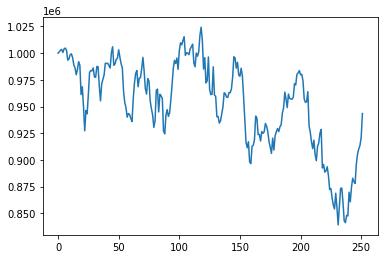

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.056600
Cumulative returns    -0.056600
Annual volatility      0.187746
Sharpe ratio          -0.217783
Calmar ratio          -0.313097
Stability              0.492607
Max drawdown          -0.180773
Omega ratio            0.964189
Sortino ratio         -0.294378
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.915344
Daily value at risk   -0.023816
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return         -0.106102
Cumulative returns    -0.105704
Annual volatility      0.191921
Sharpe ratio          -0.490846
Calmar ratio          -0.483584
Stability              0.743544
Max drawdown          -0.219408
Omega ratio            0.922039
Sortino ratio         -0.667137
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.915025
Daily value at risk   -0.024554
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Start date,2021-10-29
End date,2022-10-28
Total months,12
,Backtest
Annual return,-5.66%
Cumulative returns,-5.66%
Annual volatility,18.775%
Sharpe ratio,-0.22
Calmar ratio,-0.31
Stability,0.49
Max drawdown,-18.077%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.08,2022-04-20,2022-09-30,NaT,NaN
1,8.10,2022-01-04,2022-03-08,2022-03-25,59
2,7.72,2021-11-08,2021-12-01,2022-01-04,42
3,2.76,2022-03-30,2022-04-12,2022-04-19,15
4,0.28,2021-11-03,2021-11-04,2021-11-05,3


Stress Events,mean,min,max
New Normal,-0.02%,-3.89%,3.00%


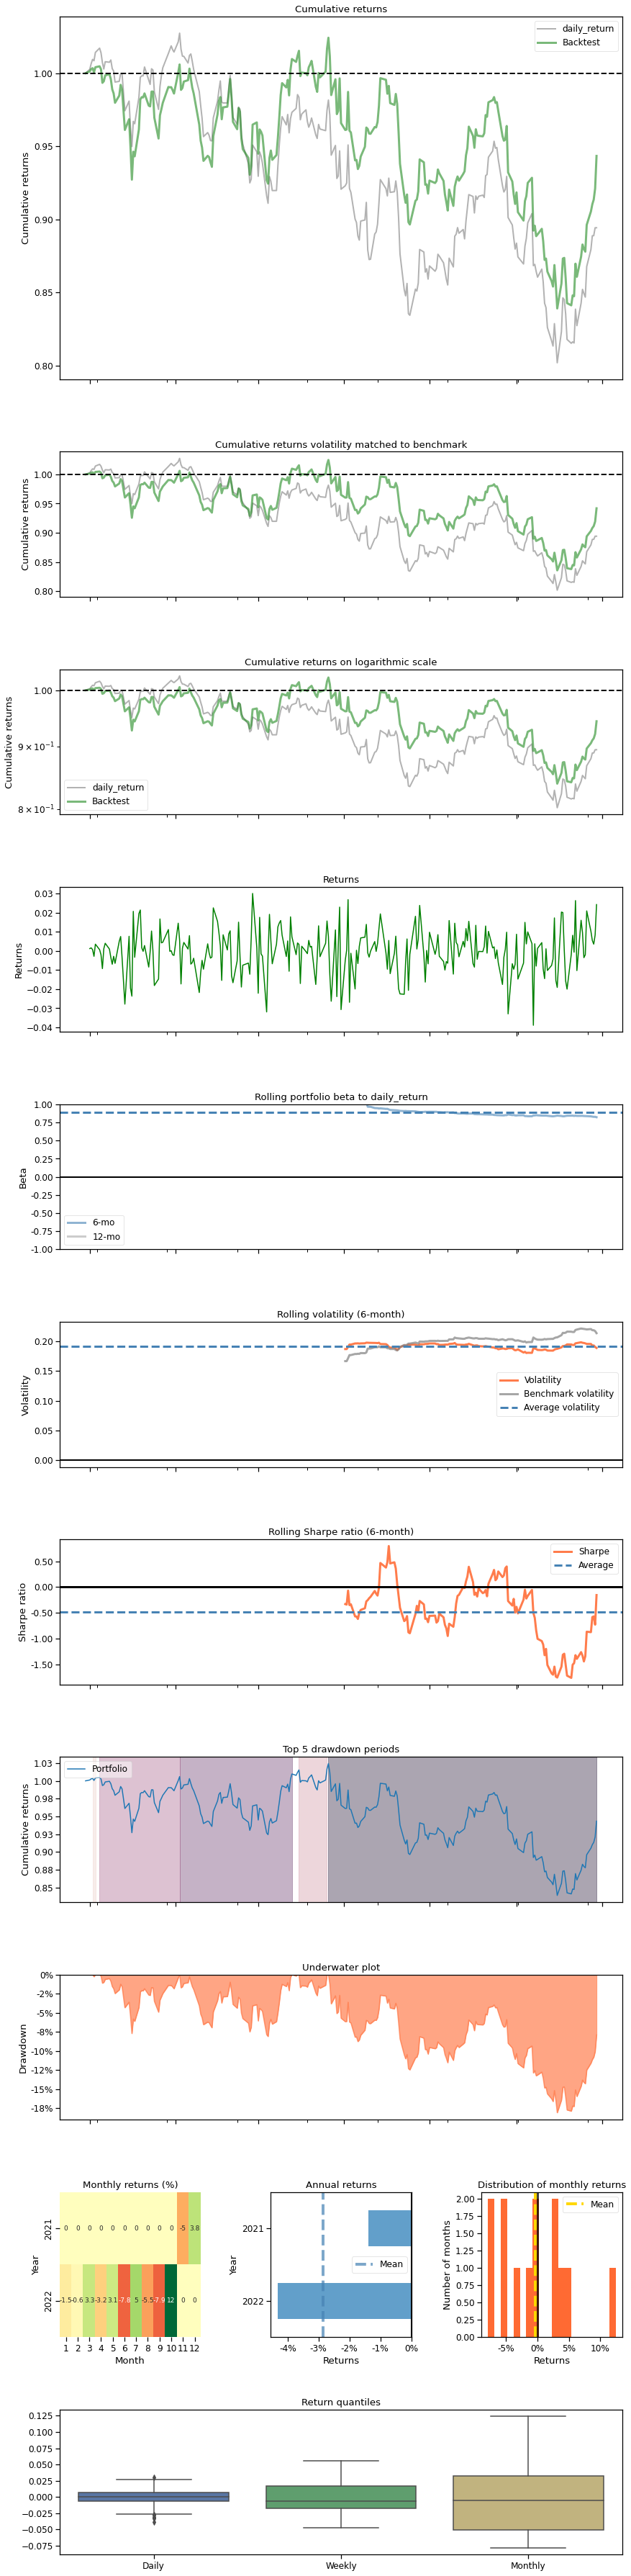

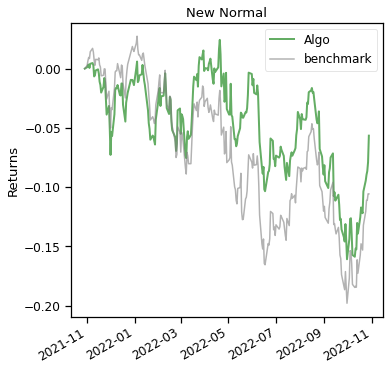

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

**Part 8: Run Alpaca Trade for NVDA**



In [ ]:
!pip install alpaca-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install alpaca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as datetime
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
#from alpaca.trading.requests import PositionsRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import LimitOrderRequest

# #I make a cryptocurrency trading bot and hand it a $1000 dollars and leave it to trade that unsupervised for a week.

# # paper=True enables paper trading
trading_client = TradingClient('PK57DYAXHE4VIR8614IC', 'JT8WhOYcaiDGilVXdt4UDnJA7OjVV23UwUHntj3I', paper=True)

# preparing orders
buy_order_data = MarketOrderRequest(
                    symbol="NVDA",
                    qty=1,
                    side=OrderSide.BUY,
                    time_in_force=TimeInForce.DAY
                    )

sell_order_data = MarketOrderRequest(
                    symbol="NVDA",
                    qty=1,
                    side=OrderSide.SELL,
                    time_in_force=TimeInForce.DAY
                    )

# Check for open positions before placing a sell order
#positions_data = PositionsRequest()
#positions = trading_client.list_positions(positions_data)
positions = 1

if DRLEnsembleAGent.Sharpe > 0.4:
    # Place a buy order
    buy_order = trading_client.submit_order(order_data=buy_order_data)
    print("Buy NVDA Trade Placed. Sharpe is " + DRLEnsembleAGent.Sharpe)
elif DRLEnsembleAGent.Sharpe < 0.2:
    if len(positions) == 0:
        # No open positions, so no need to sell
        print("No positions to sell.")
    else:
        # Place a sell order
        sell_order = trading_client.submit_order(order_data=sell_order_data)
        print("Sell NVDA Trade Placed. Sharpe is " + DRLEnsembleAGent.Sharpe)
else:
    # No trades for today
    print("No trades for today")




NameError: ignored